In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import display, clear_output

In [2]:
from functools import partial
import random
import pickle

import numpy as np
from PIL import Image

from utils import *
from image_completion import *

## constants

In [3]:
PATCH_SIZE = 10  # about how often does the texture repeat itself
MATCH_SELECTION_STD = 3  # how much of a chance to give to next-to-closest candidate pixels

In [4]:
EXAMPLE = 'donkey'
GREYSCALE = False

IMAGE_PATH  = f'examples/{EXAMPLE}.jpg'        # what to fill
HOLE_PATH   = f'examples/{EXAMPLE}-hole.png'   # where to fill
SEARCH_PATH = f'examples/{EXAMPLE}-search.png' # where to look for matching texture
RESULT_PATH = f'examples/{EXAMPLE}-result.jpg' # save after completing

In [5]:
slice_centered_in_ = partial(slice_centered_in, length=PATCH_SIZE)
compute_ssd_ = partial(compute_ssd, patch_side_len=PATCH_SIZE)
copy_patch_ = partial(copy_patch, patch_side_len=PATCH_SIZE)

## input

In [6]:
im, hole_mask, punctured_im, searchable, searchable_mask = \
    read_images(IMAGE_PATH, HOLE_PATH, SEARCH_PATH, PATCH_SIZE, GREYSCALE)
n_empty_pixels = hole_mask.sum()

original image, size (304, 220)


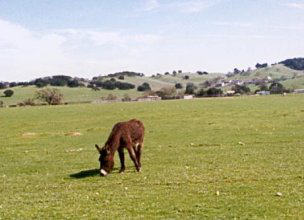

In [7]:
print('original image, size', im.size)
im

where to replace:


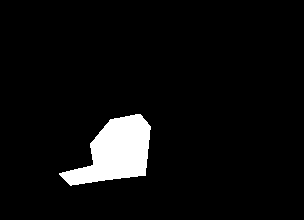


punctured image:


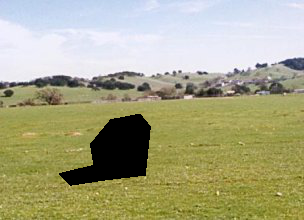

In [8]:
print('where to replace:')
display(convert_to_image(hole_mask))

print('\npunctured image:')
display(convert_to_image(punctured_im))

where to seek a match:


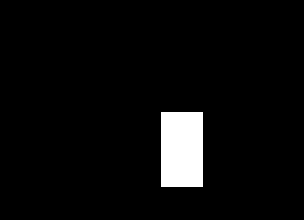

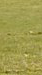

In [9]:
print('where to seek a match:')
display(convert_to_image(searchable_mask))
display(convert_to_image(searchable))

## step by step

candidates lie on the edge of the hole:


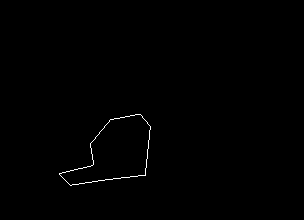

In [10]:
on_edge_mask = find_edge(hole_mask)

print('candidates lie on the edge of the hole:')
convert_to_image(on_edge_mask)

patch to fill:


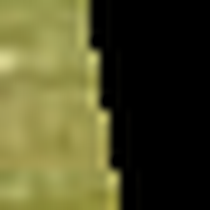


where to fill (black):


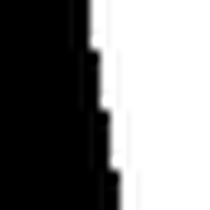

In [11]:
# pick a random pixel on the edge to be the center of the patch to fill
patch_to_fill_center = random_sample(zip(*on_edge_mask.nonzero()))
patch_to_fill = punctured_im[slice_centered_in_(patch_to_fill_center)]
is_fillable_mask = hole_mask[slice_centered_in_(patch_to_fill_center)]

print('patch to fill:') 
display(convert_to_image(patch_to_fill, 10))

print('\nwhere to fill (black):') 
display(convert_to_image(is_fillable_mask, 10))

---

In [12]:
%time ssd_matrix = compute_ssd_(patch_to_fill, searchable, is_fillable_mask)

CPU times: user 2.4 s, sys: 28.8 ms, total: 2.43 s
Wall time: 2.42 s


heatmap of distances from target patch to candidates in the searchable area:


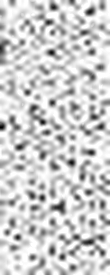

In [13]:
print('heatmap of distances from target patch to candidates in the searchable area:')
convert_to_image(ssd_matrix, 5)

---

In [14]:
# select closest patch (with a bit of stochasticity)
indices_of_closest = ssd_matrix.argsort(axis=None)  # on the raveled matrix
selected_pos = constrain_index(random.gauss(0, MATCH_SELECTION_STD), len(indices_of_closest))
match_center = np.unravel_index(indices_of_closest[selected_pos], ssd_matrix.shape)
match_center = (match_center[0] + PATCH_SIZE, match_center[1] + PATCH_SIZE)

texture patch selected as best:


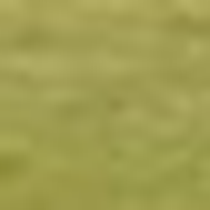


to fill this:


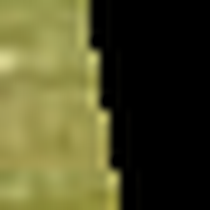

In [15]:
print('texture patch selected as best:')
selected = searchable[slice_centered_in_(match_center)]
display(convert_to_image(selected, 10))

print('\nto fill this:') 
display(convert_to_image(patch_to_fill, 10))

---

before:


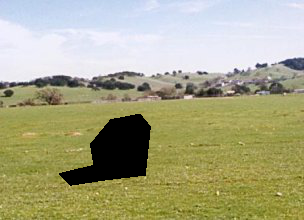


after:


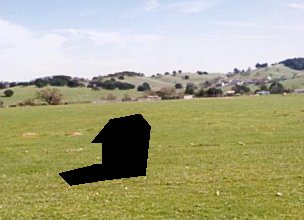

In [16]:
print('before:')
display(convert_to_image(punctured_im))

copy_patch_(punctured_im, patch_to_fill_center, searchable, match_center, is_fillable_mask)

print('\nafter:')
display(convert_to_image(punctured_im))

In [17]:
# since we just filled it, the pixels in the patch are neither empty, nor on the edge
hole_mask[slice_centered_in_(patch_to_fill_center)] = False
on_edge_mask[slice_centered_in_(patch_to_fill_center)] = False

## movie

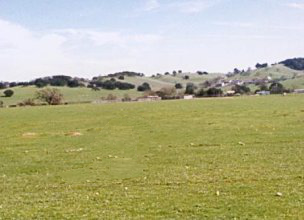

0.0% left
CPU times: user 1min 26s, sys: 1.05 s, total: 1min 28s
Wall time: 1min 27s


In [18]:
%%time
for punctured_im, hole_mask in fill_hole(hole_mask, punctured_im, searchable, PATCH_SIZE, MATCH_SELECTION_STD):
    clear_output()
    display(convert_to_image(punctured_im))
    print(f'{hole_mask.sum() / n_empty_pixels:.1%} left')

## result

original:


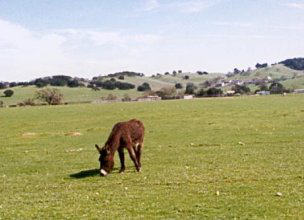


filled:


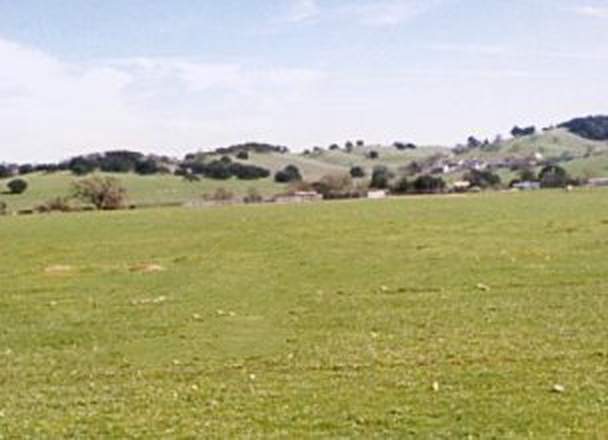

In [19]:
print('original:')
display(im)

print('\nfilled:')
display(convert_to_image(punctured_im, 2))

In [20]:
Image.fromarray(punctured_im).save(RESULT_PATH)